In [1]:
import torch
import yaml
import os
import sys
import matplotlib.pyplot as plt

parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

from models import *
from data_module import *
from forecast_module import *
from evaluation_module import *
from helpers import *
from observation_module import *
from tests.test_model import *
from visualisations import *

set_global_seed(42)

SCRIPT_DIR = os.getcwd()
sys.path.append(os.path.dirname(SCRIPT_DIR))
print(SCRIPT_DIR) 

models = ['mlp', 'lstm', 'xgb']

cpu
/etc/ecmwf/nfs/dh1_home_a/pamw/PycharmProjects/forecast-horizons/ecland-emulator
/etc/ecmwf/nfs/dh1_home_a/pamw/PycharmProjects/forecast-horizons/ecland-emulator/notebooks


/perm/pamw/venvs/myevalenv/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


To explore station data and ECLand forecasts, we load the untransformed data and plot it. ECLand slightly overestimates initial soil conditions in January, but most notably is the larger variance compared to the measurements in the first layer. From the dataset we loaded, we select the same global mean and standard deviation from the synthetic data to also z-score the station data. Then we explore their overlay. 
After, we create a hybrid data set with the z-scored station data for soil temperature, that we use for the prognostic initialsation - instead of the ECLand simulations as before. Then we initialise the model with the hybrid data and run the forecast

Extracted year: 2022
Matched station with grid cell:  4106
Resampling to 6-hourly mean.
Length of data set: 1460


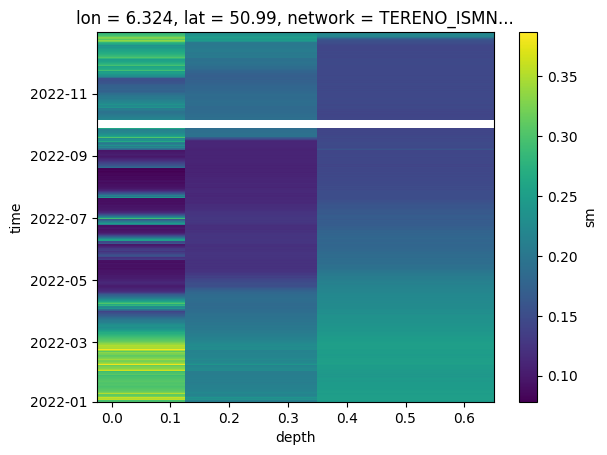

In [2]:
Gevenich = ObservationModule(station = 'soil_TERENO_ISMN_2022.nc', 
                             variable = 'sm') # Initialise the Observation Module with the default Station (Gevenich)
Gevenich.load_station() # Load station data
Gevenich.load_forcing() # Load forcing for matching data base with station data
closest_grid_cell = Gevenich.match_station_with_forcing() # Match the station with clostest grid cell and extract the index of the grid cell

station_data = Gevenich.process_station_data() 
Gevenich.plot_station_data()

Opening ../../configs/mlp_emulator.yaml for experiment configuration.
{'batch_size': 4, 'clim_feats': ['clim_clake', 'clim_ldepth', 'clim_ctype', 'clim_cell_area', 'clim_glm', 'clim_cu', 'clim_cvh', 'clim_cvl', 'clim_tvh', 'clim_tvl', 'clim_sotype', 'clim_geopot', 'clim_sdfor', 'clim_sdor', 'clim_theta_cap', 'clim_theta_pwp', 'clim_veg_covh', 'clim_veg_covl', 'clim_veg_z0mh', 'clim_veg_z0ml', 'clim_veg_rsminh', 'clim_veg_rsminl'], 'continue_training': False, 'db_path': '/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h_euro.zarr', 'device': 'cpu', 'devices': 1, 'diag_transform': 'zscoring', 'dropout': 0.1852693061424568, 'dyn_transform': 'zscoring', 'dynamic_feats': ['met_ctpf', 'met_lwdown', 'met_psurf', 'met_qair', 'met_rainf', 'met_swdown', 'met_snowf', 'met_tair', 'met_wind_e', 'met_wind_n', 'lai_hv', 'lai_lv'], 'end_year': 2019, 'file_path': '/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h_euro.zarr', 'hidden_dim': [122, 47, 103, 117],

/etc/ecmwf/nfs/dh1_home_a/pamw/PycharmProjects/forecast-horizons/ecland-emulator/forecast_module.py:176: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.loa

Model to device: cpu
Initialised prediction.
Setting model to evaluation mode
on step 0...
on step 1000...
--- 0.2086038589477539 seconds ---
--- 0.0034767309824625652 minutes ---
y_prog shape:  torch.Size([1335, 1, 7])
y_prog_prediction shape:  torch.Size([1335, 1, 7])
Backtransforming
Opening ../../configs/lstm_emulator.yaml for experiment configuration.
{'clim_feats': ['clim_clake', 'clim_ldepth', 'clim_ctype', 'clim_cell_area', 'clim_glm', 'clim_cu', 'clim_cvh', 'clim_cvl', 'clim_tvh', 'clim_tvl', 'clim_sotype', 'clim_geopot', 'clim_sdfor', 'clim_sdor', 'clim_theta_cap', 'clim_theta_pwp', 'clim_veg_covh', 'clim_veg_covl', 'clim_veg_z0mh', 'clim_veg_z0ml', 'clim_veg_rsminh', 'clim_veg_rsminl'], 'dynamic_feats': ['met_ctpf', 'met_lwdown', 'met_psurf', 'met_qair', 'met_rainf', 'met_swdown', 'met_snowf', 'met_tair', 'met_wind_e', 'met_wind_n', 'lai_hv', 'lai_lv'], 'targets_prog': ['swvl1', 'swvl2', 'swvl3', 'stl1', 'stl2', 'stl3', 'snowc'], 'targets_diag': None, 'file_path': '/ec/res4/

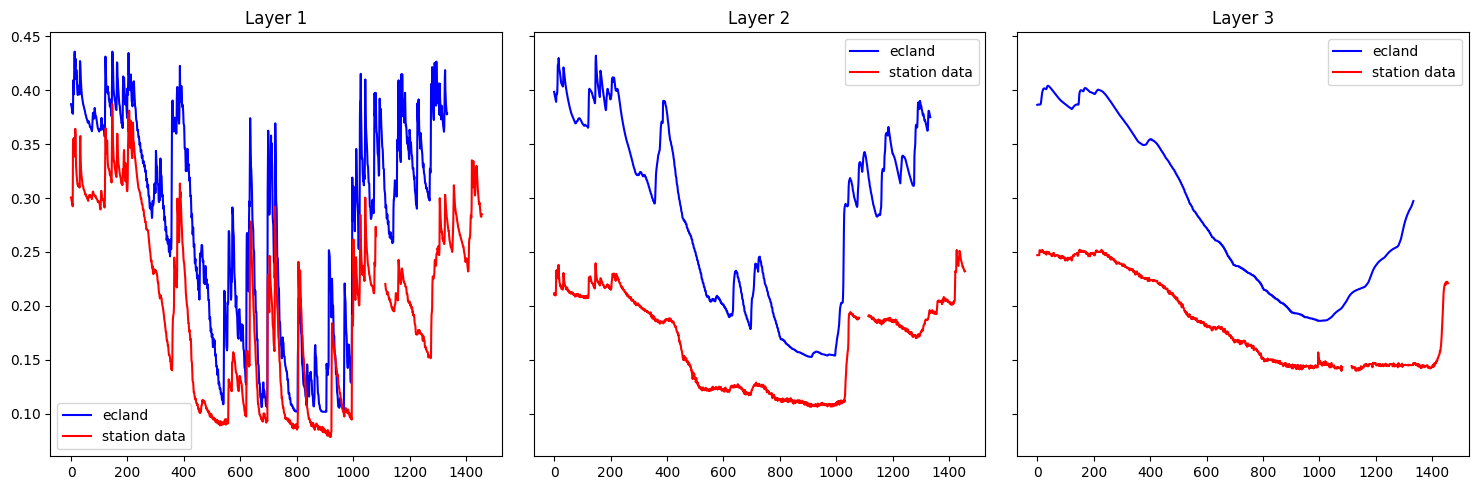

In [3]:
dynamic_features_dict = {}
dynamic_features_prediction_dict = {}

for mod in models:

    # initialise model with config file
    if mod == 'mlp':
        CONFIG = load_config(config_path = '../../configs/mlp_emulator.yaml')
        HPARS = load_hpars(use_model = '../mlp')
        ForecastModel = ForecastModuleMLP(hpars=HPARS, config=CONFIG)    
    elif mod == 'lstm':
        CONFIG = load_config(config_path = '../../configs/lstm_emulator.yaml')
        HPARS = load_hpars(use_model = '../lstm')
        ForecastModel = ForecastModuleLSTM(hpars=HPARS, config=CONFIG)
    elif mod == 'xgb':
        CONFIG = load_config(config_path = '../../configs/xgb_emulator.yaml')
        HPARS = None
        ForecastModel = ForecastModuleXGB(hpars=HPARS, config=CONFIG)

    CONFIG['x_slice_indices'] = closest_grid_cell # adjust the index of the grid cell in the config file before initialising the models

    dataset = ForecastModel.initialise_dataset()
    model = ForecastModel.load_model()
    x_static, x_met, y_prog = ForecastModel.load_test_data(dataset)  

    y_prog_hybrid = y_prog.clone()
    station_data_transformed = Gevenich.transform_station_data(dataset=dataset, target_variables=CONFIG['targets_eval'])
    y_prog_hybrid[...,Gevenich.matching_indices] = station_data_transformed[:y_prog_hybrid.shape[0]]

    if CONFIG["model"] == 'lstm':
        ForecastModel.handle_hindcast(skip=True)
    dynamic_features, dynamic_features_prediction = ForecastModel.run_forecast(initial_conditions=y_prog_hybrid[0,...])
    dynamic_features, dynamic_features_prediction = ForecastModel.backtransformation()

    dynamic_features_dict[mod] = dynamic_features
    dynamic_features_prediction_dict[mod] = dynamic_features_prediction


plot_station_data(y_prog, station_data_transformed, 
                  matching_indices= Gevenich.matching_indices,
                  save_to= '../results/station_data.pdf')


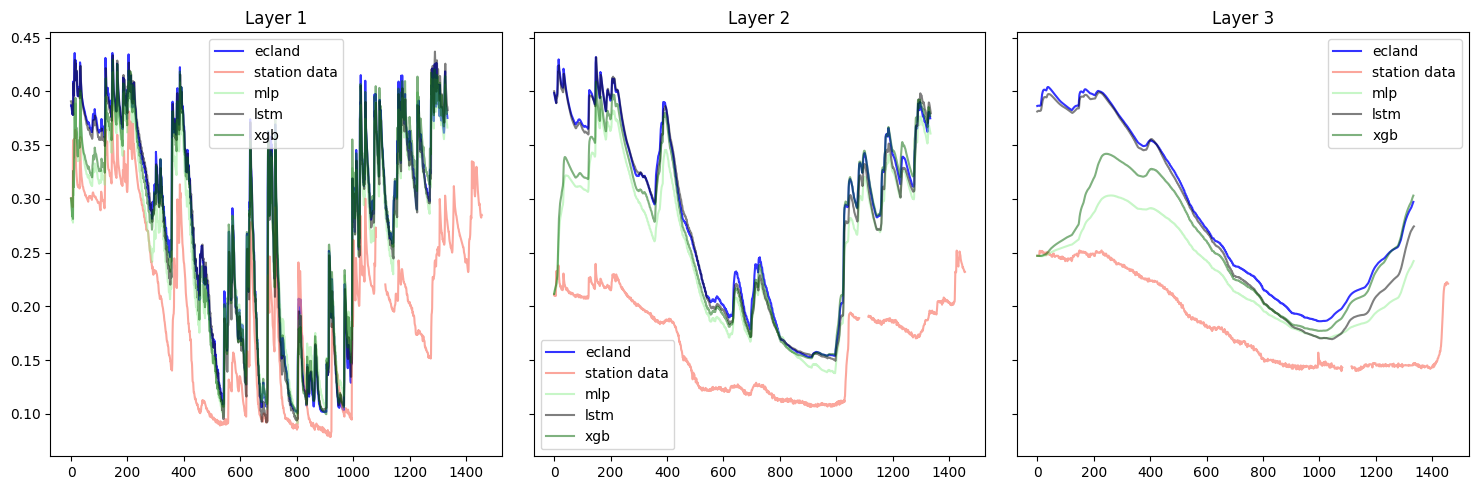

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True) 

ax[0].plot(dynamic_features_dict['mlp'][:,:,Gevenich.matching_indices[0]], color="blue", label="ecland", alpha = 0.8)
ax[0].plot(station_data[:,:,0], color="salmon", label="station data", alpha = 0.7)
ax[0].plot(dynamic_features_prediction_dict['mlp'][:,:,Gevenich.matching_indices[0]], color="lightgreen", label="mlp", alpha = 0.5)
ax[0].plot(dynamic_features_prediction_dict['lstm'][:,:,Gevenich.matching_indices[0]], color="black", label="lstm", alpha = 0.5)
ax[0].plot(dynamic_features_prediction_dict['xgb'][:,:,Gevenich.matching_indices[0]], color="darkgreen", label="xgb", alpha = 0.5)
ax[0].set_title("Layer 1")
ax[0].legend()

ax[1].plot(dynamic_features[:,:,Gevenich.matching_indices[1]], color="blue", label="ecland", alpha = 0.8)
ax[1].plot(station_data[:,:,1], color="salmon", label="station data", alpha = 0.7)
ax[1].plot(dynamic_features_prediction_dict['mlp'][:,:,Gevenich.matching_indices[1]], color="lightgreen", label="mlp", alpha = 0.5)
ax[1].plot(dynamic_features_prediction_dict['lstm'][:,:,Gevenich.matching_indices[1]], color="black", label="lstm", alpha = 0.5)
ax[1].plot(dynamic_features_prediction_dict['xgb'][:,:,Gevenich.matching_indices[1]], color="darkgreen", label="xgb", alpha = 0.5)
ax[1].set_title("Layer 2")
ax[1].legend()

ax[2].plot(dynamic_features[:,:,Gevenich.matching_indices[2]], color="blue", label="ecland", alpha = 0.8)
ax[2].plot(station_data[:,:,2], color="salmon", label="station data", alpha = 0.7)  
ax[2].plot(dynamic_features_prediction_dict['mlp'][:,:,Gevenich.matching_indices[2]], color="lightgreen", label="mlp", alpha = 0.5)
ax[2].plot(dynamic_features_prediction_dict['lstm'][:,:,Gevenich.matching_indices[2]], color="black", label="lstm", alpha = 0.5)
ax[2].plot(dynamic_features_prediction_dict['xgb'][:,:,Gevenich.matching_indices[2]], color="darkgreen", label="xgb", alpha = 0.5)
ax[2].set_title("Layer 3")
ax[2].legend()

plt.tight_layout()
plt.show()


Then we evaluate both ECLand and AIland forecast:
1) Directly against the station data: $D(y_{ai}, y)$ and $D(y_{ec}, y)$
2) Then both against the observed climatology: $D(y_{ai}, y) / D(y_c, y)$ and $D(y_{ec}, y) / D(y_c, y)$

Dependent on what we want to report, we look at the ensemble scores over time, or at the spatially aggregated scores. D can here be the MSE, such that with 2) we compute the MSESS. It could also be the ACC.

Evaluation with mae


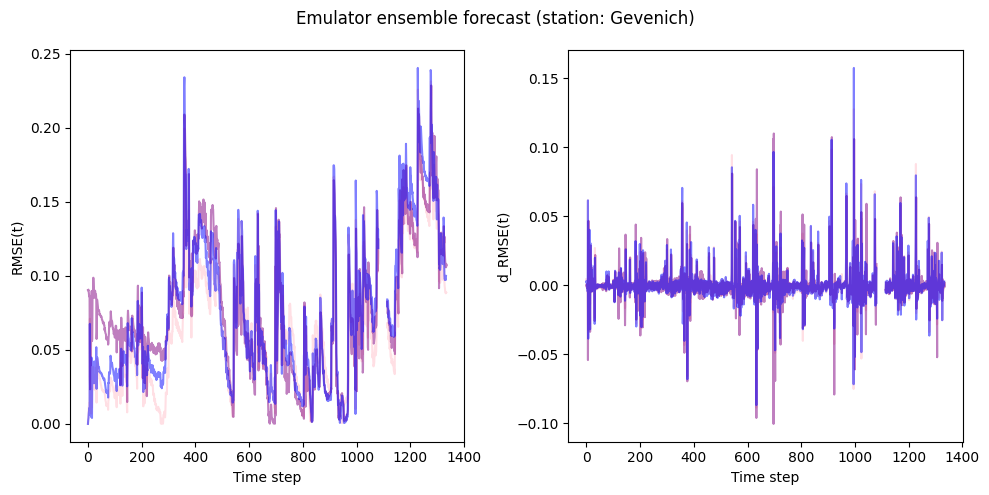

In [7]:
EvaluateModel = EvaluationModule(score = 'mae')

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True) 
cs = ["pink", "purple", "blue"]
rmses = []
rmse_change = []
for mod, c in zip(models, cs):
    rmse_layer1 = EvaluateModel.evaluate_target(y_prog=station_data[..., 0], y_prog_prediction=dynamic_features_prediction_dict[mod][..., Gevenich.matching_indices[0]])
    rmse_layer1_change = rmse_layer1[1:] - rmse_layer1[:-1]
    ax[0].plot(rmse_layer1, color = c, alpha = 0.5)
    ax[1].plot(rmse_layer1_change, color=c, alpha = 0.5)  
    #rmses.append(rmse_layer1)
    #rmse_change.append(rmse_layer1_change)
#ax[0].plot(np.mean(np.array(rmses), axis=0), color = "black", alpha = 0.5)
#ax[1].plot(torch.mean(torch.stack(rmse_layer1_change), axis=0), color="black", alpha = 0.5)  
ax[0].set_ylabel("RMSE(t)")
ax[1].set_ylabel("d_RMSE(t)")
ax[0].set_xlabel("Time step")
ax[1].set_xlabel("Time step")
fig.suptitle("Emulator ensemble forecast (station: Gevenich)")
plt.tight_layout()
plt.show()

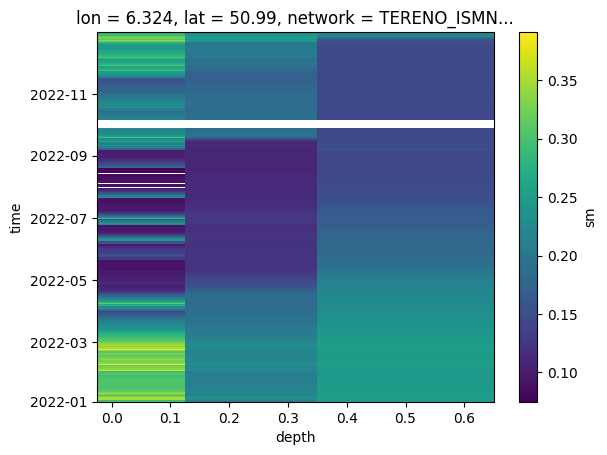

In [22]:
Gevenich.station_data['sm'].plot()

The following steps are so far applicable only with the MLP. Here, we slightly perturb model forecast after initialisation, magnitude defined by sigma. The we run multiple deterministic forecasts with this disturbance (defined by ensemble).

In [ ]:
initial_vector = y_prog[0,...]
size = 10
sigma = 0.1

ensemble_prediction = []

for i in range(size):
    dynamic_features, dynamic_features_prediction = ForecastModel.run_forecast(initial_vector, perturbation = sigma)
    dynamic_features, dynamic_features_prediction = ForecastModel.backtransformation()
    ensemble_prediction.append(dynamic_features_prediction)

ensemble_prediction = torch.stack(ensemble_prediction)
print(ensemble_prediction.shape)
print(ensemble_prediction)

Initialised prediction.
Setting model to evaluation mode
on step 0...
on step 1000...
--- 0.20027589797973633 seconds ---
--- 0.0033379316329956053 minutes ---
y_prog shape:  torch.Size([1335, 1, 7])
y_prog_prediction shape:  torch.Size([1335, 1, 7])
Backtransforming
Initialised prediction.
Setting model to evaluation mode
on step 0...
on step 1000...
--- 0.1995704174041748 seconds ---
--- 0.0033261736234029135 minutes ---
y_prog shape:  torch.Size([1335, 1, 7])
y_prog_prediction shape:  torch.Size([1335, 1, 7])
Backtransforming
Initialised prediction.
Setting model to evaluation mode
on step 0...
on step 1000...
--- 0.19954466819763184 seconds ---
--- 0.0033257444699605304 minutes ---
y_prog shape:  torch.Size([1335, 1, 7])
y_prog_prediction shape:  torch.Size([1335, 1, 7])
Backtransforming
Initialised prediction.
Setting model to evaluation mode
on step 0...
on step 1000...
--- 0.20212340354919434 seconds ---
--- 0.0033687233924865724 minutes ---
y_prog shape:  torch.Size([1335, 1, 7

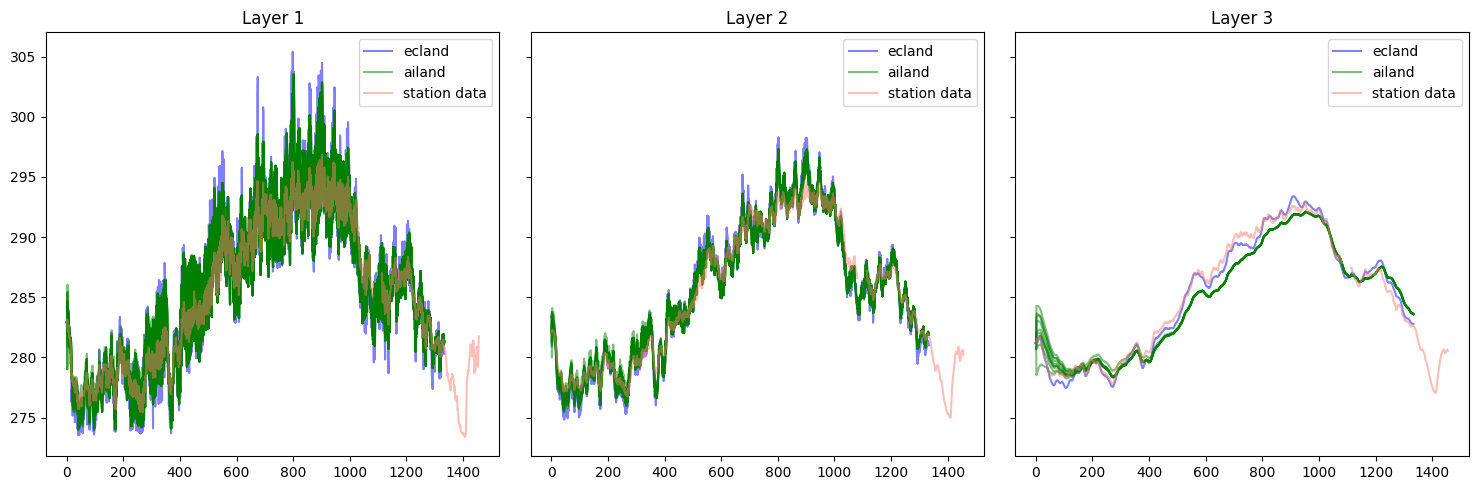

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True) 

ax[0].plot(dynamic_features[:,:,3], color="blue", label="ecland", alpha = 0.5)
for i in range(size):
    label = "ailand" if i == 0 else None
    ax[0].plot(ensemble_prediction[i, :,:,3], color="green", label=label, alpha = 0.5)
ax[0].plot(station_data[:,:,0], color="salmon", label="station data", alpha = 0.5)
ax[0].set_title("Layer 1")
ax[0].legend()

ax[1].plot(dynamic_features[:,:,4], color="blue", label="ecland", alpha = 0.5)
for i in range(size):
    label = "ailand" if i == 0 else None
    ax[1].plot(ensemble_prediction[i, :,:,4], color="green", label=label, alpha = 0.5)
ax[1].plot(station_data[:,:,1], color="salmon", label="station data", alpha = 0.5)
ax[1].set_title("Layer 2")
ax[1].legend()

ax[2].plot(dynamic_features[:,:,5], color="blue", label="ecland", alpha = 0.5)
for i in range(size):
    label = "ailand" if i == 0 else None
    ax[2].plot(ensemble_prediction[i, :,:,5], color="green", label=label, alpha = 0.5)
ax[2].plot(station_data[:,:,2], color="salmon", label="station data", alpha = 0.5)  
ax[2].set_title("Layer 3")
ax[2].legend()

plt.tight_layout()
plt.show()


In [ ]:
mse_obs = np.sqrt(np.sum((dynamic_features_prediction - dynamic_features)**2, axis = 1))*(1/spatial_fields)
mse_clim = np.sqrt(np.sum((climatology - dynamic_features)**2, axis = 1))*(1/spatial_fields)
msess = 1 - (mse_obs[...,0]/mse_clim[...,0])
plt.plot(msess)

In [ ]:
mse_obs = np.sqrt(np.sum((dynamic_features_prediction - dynamic_features)**2, axis = 1))*(1/spatial_fields)
mse_clim = np.sqrt(np.sum((climatology - dynamic_features)**2, axis = 1))*(1/spatial_fields)

mse_obs = np.sum(np.abs(dynamic_features_prediction - dynamic_features), axis = 1)*(1/spatial_fields)
mse_clim = np.sum(np.abs(climatology - dynamic_features), axis = 1)*(1/spatial_fields)


msess_L1 = 1 - (mse_obs[...,0]/mse_clim[...,0])
msess_L2 = 1 - (mse_obs[...,1]/mse_clim[...,1])
msess_L3 = 1 - (mse_obs[...,2]/mse_clim[...,2])

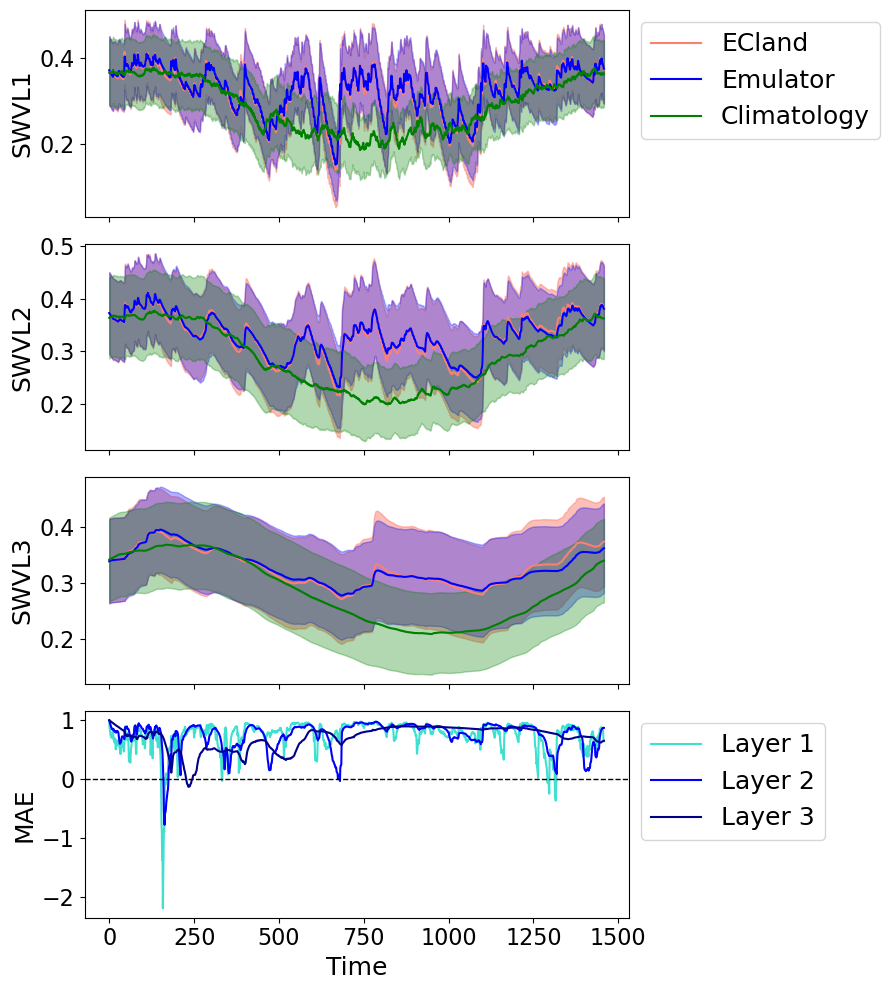

In [ ]:
# Calculate mean and standard deviations
L1mean1 = np.mean(dynamic_features[...,0], axis=1)
L1std1 = dynamic_features[...,0].std(axis=1)

L1mean2 = np.mean(dynamic_features_prediction[...,0], axis=1)
L1std2 = dynamic_features_prediction[...,0].std(axis=1)

L1mean3 = np.mean(climatology_mu[:len(dynamic_features),:,0], axis=1)
L1std3 = climatology_mu[:len(dynamic_features),:,0].std(axis=1)

L2mean1 = np.mean(dynamic_features[...,1], axis=1)
L2std1 = dynamic_features[...,1].std(axis=1)

L2mean2 = np.mean(dynamic_features_prediction[...,1], axis=1)
L2std2 = dynamic_features_prediction[...,1].std(axis=1)

L2mean3 = np.mean(climatology_mu[:len(dynamic_features),:,1], axis=1)
L2std3 = climatology_mu[:len(dynamic_features),:,1].std(axis=1)

L3mean1 = np.mean(dynamic_features[...,2], axis=1)
L3std1 = dynamic_features[...,2].std(axis=1)

L3mean2 = np.mean(dynamic_features_prediction[...,2], axis=1)
L3std2 = dynamic_features_prediction[...,2].std(axis=1)

L3mean3 = np.mean(climatology_mu[:len(dynamic_features),:,2], axis=1)
L3std3 = climatology_mu[:len(dynamic_features),:,2].std(axis=1)

# Assuming L1mean1, L1std1, L1mean2, L1std2, etc. are defined
x = np.arange(1459)  # Example x-axis values for the tensors

# Create the plot with four subplots (4 rows, 1 column)
fig, axs = plt.subplots(4, 1, figsize=(9,10), sharex=True)

# Plot for Layer 1
axs[0].fill_between(x, L1mean1 - L1std1, L1mean1 + L1std1, color='salmon', alpha=0.5)
axs[0].plot(x, L1mean1, label='ECland', color='salmon')
axs[0].fill_between(x, L1mean2 - L1std2, L1mean2 + L1std2, color='blue', alpha=0.3)
axs[0].plot(x, L1mean2, label='Emulator', color='blue')
axs[0].fill_between(x, L1mean3 - L1std3, L1mean3 + L1std3, color='green', alpha=0.3)
axs[0].plot(x, L1mean3, label='Climatology', color='green')
axs[0].set_ylabel('SWVL1', fontsize=18)
axs[0].legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))


# Plot for Layer 2
axs[1].fill_between(x, L2mean1 - L2std1, L2mean1 + L2std1, color='salmon', alpha=0.5)
axs[1].plot(x, L2mean1, label='ECland', color='salmon')
axs[1].fill_between(x, L2mean2 - L2std2, L2mean2 + L2std2, color='blue', alpha=0.3)
axs[1].plot(x, L2mean2, label='Emulator', color='blue')
axs[1].fill_between(x, L2mean3 - L2std3, L2mean3 + L2std3, color='green', alpha=0.3)
axs[1].plot(x, L2mean3, label='Climatology', color='green')
axs[1].set_ylabel('SWVL2', fontsize=18)
axs[1].legend().remove()

# Plot for Layer 3
axs[2].fill_between(x, L3mean1 - L3std1, L3mean1 + L3std1, color='salmon', alpha=0.5)
axs[2].plot(x, L3mean1, label='ECland', color='salmon')
axs[2].fill_between(x, L3mean2 - L3std2, L3mean2 + L3std2, color='blue', alpha=0.3)
axs[2].plot(x, L3mean2, label='Emulator', color='blue')
axs[2].fill_between(x, L3mean3 - L3std3, L3mean3 + L3std3, color='green', alpha=0.3)
axs[2].plot(x, L3mean3, label='Climatology', color='green')
axs[2].set_ylabel('SWVL3', fontsize=18)
axs[2].legend().remove()

# Plot for MAE in Layer 1, 2, 3
axs[3].plot(msess_L1, label='Layer 1', color='turquoise')
axs[3].plot(msess_L2, label='Layer 2', color='blue')
axs[3].plot(msess_L3, label='Layer 3', color='darkblue')
axs[3].axhline(0, color='black', linestyle='--', linewidth=1)  # Add the horizontal line at y=0
axs[3].set_xlabel('Time', fontsize=18)
axs[3].set_ylabel('MAE', fontsize=18)
axs[3].legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))

axs[0].tick_params(axis='both', labelsize=16)
axs[1].tick_params(axis='both', labelsize=16)
axs[2].tick_params(axis='both', labelsize=16)
axs[3].tick_params(axis='both', labelsize=16)

# Adjust layout to remove vertical space between subplots
plt.subplots_adjust(hspace=0.1)  # Adjust the height space between plots

# Display the plot
plt.tight_layout()
plt.savefig("plots/ailand_horizons.pdf")
plt.show()
